In [1]:
library(tidyverse)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
options(repr.matrix.max.rows=10)
options(repr.plot.height=10,
        repr.plot.width=10)

In [3]:
source("utility.R")
source("recommender.r")


Attaching package: ‘assertthat’

The following object is masked from ‘package:tibble’:

    has_name



In [4]:
experiment.time = 50
final.result = NULL

for (i in 1:experiment.time) {
    
    preference = generate_IBP(943, 1682 * 0.1)
    allItems = unique(preference$itemId)
    observation = sample_popular(preference, 0.1)
    
    test.sets = partition_users(observation)
    test.data = NULL
    train.data = NULL
    candidate.data = NULL
    ideal.relevance.observation = NULL
    ideal.relevance.groundtruth = NULL

    for (partNum in 1:5) {
        testPartRowNumber = test.sets %>% filter(part == partNum)
        test = observation %>%
            filter(row_number() %in% testPartRowNumber$rowNumber) %>%
            mutate(part=partNum)
        train = observation %>%
            anti_join(test) %>%
            mutate(part=partNum)

        candidates = test %>%
            group_by(userId) %>%
            summarize(itemId=list(allItems)) %>%
            ungroup() %>%
            unnest(itemId) %>%
            anti_join(train) %>%
            mutate(part=partNum)

        idealRelObv = observation %>%
            filter(userId %in% unique(test$userId)) %>%
            mutate(rel=1,
                   part=partNum)
        idealRelGroundTruth = preference %>%
            filter(userId %in% unique(test$userId)) %>%
            mutate(rel=1,
                   part=partNum)

        test.data = bind_rows(test.data, test)
        train.data = bind_rows(train.data, train)
        candidate.data = bind_rows(candidate.data, candidates)
        ideal.relevance.observation = bind_rows(ideal.relevance.observation, idealRelObv)
        ideal.relevance.groundtruth = bind_rows(ideal.relevance.groundtruth, idealRelGroundTruth)  
    }
    
    ndcg.observation.oracle = NULL
    ndcg.groudtruth.oracle = NULL

    precision.observation.oracle = NULL
    precision.groudtruth.oracle = NULL

    recall.observation.oracle = NULL
    recall.groudtruth.oracle = NULL

    reciprocal.rank.observation.oracle = NULL
    reciprocal.rank.groudtruth.oracle = NULL

    avg.precision.observation.oracle = NULL
    avg.precision.groudtruth.oracle = NULL

    hit.observation.oracle = NULL
    hit.groudtruth.oracle = NULL

    for (partNum in 1:5) {
        candidates = candidate.data %>%
            filter(part == partNum) %>%
            select(-part)
        idealRelObv = ideal.relevance.observation %>%
            filter(part == partNum) %>%
            select(-part)
        idealRelGroundTruth = ideal.relevance.groundtruth %>%
            filter(part == partNum) %>%
            select(-part)

        recommendations = recommend_oracle(candidates, preference, 10)

        metricObv = compute_ndcg(recommendations, idealRelObv, 10)
        metricGT = compute_ndcg(recommendations, idealRelGroundTruth, 10)
        ndcg.observation.oracle = bind_rows(ndcg.observation.oracle, metricObv %>% mutate(part=partNum))
        ndcg.groudtruth.oracle = bind_rows(ndcg.groudtruth.oracle, metricGT %>% mutate(part=partNum))

        metricObv = compute_precision(recommendations, idealRelObv, 10)
        metricGT = compute_precision(recommendations, idealRelGroundTruth, 10)
        precision.observation.oracle = bind_rows(precision.observation.oracle, metricObv %>% mutate(part=partNum))
        precision.groudtruth.oracle = bind_rows(precision.groudtruth.oracle, metricGT %>% mutate(part=partNum))

        metricObv = compute_recall(recommendations, idealRelObv, 10)
        metricGT = compute_recall(recommendations, idealRelGroundTruth, 10)
        recall.observation.oracle = bind_rows(recall.observation.oracle, metricObv %>% mutate(part=partNum))
        recall.groudtruth.oracle = bind_rows(recall.groudtruth.oracle, metricGT %>% mutate(part=partNum))

        metricObv = compute_reciprocal_rank(recommendations, idealRelObv, 10)
        metricGT = compute_reciprocal_rank(recommendations, idealRelGroundTruth, 10)
        reciprocal.rank.observation.oracle = bind_rows(reciprocal.rank.observation.oracle, metricObv %>% mutate(part=partNum))
        reciprocal.rank.groudtruth.oracle = bind_rows(reciprocal.rank.groudtruth.oracle, metricGT %>% mutate(part=partNum))

        metricObv = compute_average_precision(recommendations, idealRelObv, 10)
        metricGT = compute_average_precision(recommendations, idealRelGroundTruth, 10)
        avg.precision.observation.oracle = bind_rows(avg.precision.observation.oracle, metricObv %>% mutate(part=partNum))
        avg.precision.groudtruth.oracle = bind_rows(avg.precision.groudtruth.oracle, metricGT %>% mutate(part=partNum))

        metricObv = compute_hit_rate(recommendations, idealRelObv, 10)
        metricGT = compute_hit_rate(recommendations, idealRelGroundTruth, 10)
        hit.observation.oracle = bind_rows(hit.observation.oracle, metricObv %>% mutate(part=partNum))
        hit.groudtruth.oracle = bind_rows(hit.groudtruth.oracle, metricGT %>% mutate(part=partNum))

    }
    
    
    ndcg.observation.popular = NULL
    ndcg.groudtruth.popular = NULL

    precision.observation.popular = NULL
    precision.groudtruth.popular = NULL

    recall.observation.popular = NULL
    recall.groudtruth.popular = NULL

    reciprocal.rank.observation.popular = NULL
    reciprocal.rank.groudtruth.popular = NULL

    avg.precision.observation.popular = NULL
    avg.precision.groudtruth.popular = NULL

    hit.observation.popular = NULL
    hit.groudtruth.popular = NULL

    for (partNum in 1:5) {
        train = train.data %>%
            filter(part == partNum) %>%
            select(-part)
        candidates = candidate.data %>%
            filter(part == partNum) %>%
            select(-part)
        idealRelObv = ideal.relevance.observation %>%
            filter(part == partNum) %>%
            select(-part)
        idealRelGroundTruth = ideal.relevance.groundtruth %>%
            filter(part == partNum) %>%
            select(-part)

        recommendations = recommend_popular(candidates, train, 10)

        metricObv = compute_ndcg(recommendations, idealRelObv, 10)
        metricGT = compute_ndcg(recommendations, idealRelGroundTruth, 10)
        ndcg.observation.popular = bind_rows(ndcg.observation.popular, metricObv %>% mutate(part=partNum))
        ndcg.groudtruth.popular = bind_rows(ndcg.groudtruth.popular, metricGT %>% mutate(part=partNum))

        metricObv = compute_precision(recommendations, idealRelObv, 10)
        metricGT = compute_precision(recommendations, idealRelGroundTruth, 10)
        precision.observation.popular = bind_rows(precision.observation.popular, metricObv %>% mutate(part=partNum))
        precision.groudtruth.popular = bind_rows(precision.groudtruth.popular, metricGT %>% mutate(part=partNum))

        metricObv = compute_recall(recommendations, idealRelObv, 10)
        metricGT = compute_recall(recommendations, idealRelGroundTruth, 10)
        recall.observation.popular = bind_rows(recall.observation.popular, metricObv %>% mutate(part=partNum))
        recall.groudtruth.popular = bind_rows(recall.groudtruth.popular, metricGT %>% mutate(part=partNum))

        metricObv = compute_reciprocal_rank(recommendations, idealRelObv, 10)
        metricGT = compute_reciprocal_rank(recommendations, idealRelGroundTruth, 10)
        reciprocal.rank.observation.popular = bind_rows(reciprocal.rank.observation.popular, metricObv %>% mutate(part=partNum))
        reciprocal.rank.groudtruth.popular = bind_rows(reciprocal.rank.groudtruth.popular, metricGT %>% mutate(part=partNum))

        metricObv = compute_average_precision(recommendations, idealRelObv, 10)
        metricGT = compute_average_precision(recommendations, idealRelGroundTruth, 10)
        avg.precision.observation.popular = bind_rows(avg.precision.observation.popular, metricObv %>% mutate(part=partNum))
        avg.precision.groudtruth.popular = bind_rows(avg.precision.groudtruth.popular, metricGT %>% mutate(part=partNum))

        metricObv = compute_hit_rate(recommendations, idealRelObv, 10)
        metricGT = compute_hit_rate(recommendations, idealRelGroundTruth, 10)
        hit.observation.popular = bind_rows(hit.observation.popular, metricObv %>% mutate(part=partNum))
        hit.groudtruth.popular = bind_rows(hit.groudtruth.popular, metricGT %>% mutate(part=partNum))

    }
    
    
    ndcg.observation.random = NULL
    ndcg.groudtruth.random = NULL

    precision.observation.random = NULL
    precision.groudtruth.random = NULL

    recall.observation.random = NULL
    recall.groudtruth.random = NULL

    reciprocal.rank.observation.random = NULL
    reciprocal.rank.groudtruth.random = NULL

    avg.precision.observation.random = NULL
    avg.precision.groudtruth.random = NULL

    hit.observation.random = NULL
    hit.groudtruth.random = NULL

    for (partNum in 1:5) {
        candidates = candidate.data %>%
            filter(part == partNum) %>%
            select(-part)
        idealRelObv = ideal.relevance.observation %>%
            filter(part == partNum) %>%
            select(-part)
        idealRelGroundTruth = ideal.relevance.groundtruth %>%
            filter(part == partNum) %>%
            select(-part)

        recommendations = recommend_random(candidates, 10)

        metricObv = compute_ndcg(recommendations, idealRelObv, 10)
        metricGT = compute_ndcg(recommendations, idealRelGroundTruth, 10)
        ndcg.observation.random = bind_rows(ndcg.observation.random, metricObv %>% mutate(part=partNum))
        ndcg.groudtruth.random = bind_rows(ndcg.groudtruth.random, metricGT %>% mutate(part=partNum))

        metricObv = compute_precision(recommendations, idealRelObv, 10)
        metricGT = compute_precision(recommendations, idealRelGroundTruth, 10)
        precision.observation.random = bind_rows(precision.observation.random, metricObv %>% mutate(part=partNum))
        precision.groudtruth.random = bind_rows(precision.groudtruth.random, metricGT %>% mutate(part=partNum))

        metricObv = compute_recall(recommendations, idealRelObv, 10)
        metricGT = compute_recall(recommendations, idealRelGroundTruth, 10)
        recall.observation.random = bind_rows(recall.observation.random, metricObv %>% mutate(part=partNum))
        recall.groudtruth.random = bind_rows(recall.groudtruth.random, metricGT %>% mutate(part=partNum))

        metricObv = compute_reciprocal_rank(recommendations, idealRelObv, 10)
        metricGT = compute_reciprocal_rank(recommendations, idealRelGroundTruth, 10)
        reciprocal.rank.observation.random = bind_rows(reciprocal.rank.observation.random, metricObv %>% mutate(part=partNum))
        reciprocal.rank.groudtruth.random = bind_rows(reciprocal.rank.groudtruth.random, metricGT %>% mutate(part=partNum))

        metricObv = compute_average_precision(recommendations, idealRelObv, 10)
        metricGT = compute_average_precision(recommendations, idealRelGroundTruth, 10)
        avg.precision.observation.random = bind_rows(avg.precision.observation.random, metricObv %>% mutate(part=partNum))
        avg.precision.groudtruth.random = bind_rows(avg.precision.groudtruth.random, metricGT %>% mutate(part=partNum))

        metricObv = compute_hit_rate(recommendations, idealRelObv, 10)
        metricGT = compute_hit_rate(recommendations, idealRelGroundTruth, 10)
        hit.observation.random = bind_rows(hit.observation.random, metricObv %>% mutate(part=partNum))
        hit.groudtruth.random = bind_rows(hit.groudtruth.random, metricGT %>% mutate(part=partNum))

    }
    
    ndcg.observation = bind_rows(oracle=ndcg.observation.oracle, 
                                 popular=ndcg.observation.popular,
                                 random=ndcg.observation.random,
                                 .id="algorithm")
    ndcg.groudtruth = bind_rows(oracle=ndcg.groudtruth.oracle,
                                popular=ndcg.groudtruth.popular,
                                random=ndcg.groudtruth.random,
                                .id="algorithm")

    precision.observation = bind_rows(oracle=precision.observation.oracle, 
                                 popular=precision.observation.popular,
                                 random=precision.observation.random,
                                 .id="algorithm")
    precision.groudtruth = bind_rows(oracle=precision.groudtruth.oracle,
                                popular=precision.groudtruth.popular,
                                random=precision.groudtruth.random,
                                .id="algorithm")

    recall.observation = bind_rows(oracle=recall.observation.oracle, 
                                 popular=recall.observation.popular,
                                 random=recall.observation.random,
                                 .id="algorithm")
    recall.groudtruth = bind_rows(oracle=recall.groudtruth.oracle,
                                popular=recall.groudtruth.popular,
                                random=recall.groudtruth.random,
                                .id="algorithm")

    reciprocal.rank.observation = bind_rows(oracle=reciprocal.rank.observation.oracle, 
                                 popular=reciprocal.rank.observation.popular,
                                 random=reciprocal.rank.observation.random,
                                 .id="algorithm")
    reciprocal.rank.groudtruth = bind_rows(oracle=reciprocal.rank.groudtruth.oracle,
                                popular=reciprocal.rank.groudtruth.popular,
                                random=reciprocal.rank.groudtruth.random,
                                .id="algorithm")

    avg.precision.observation = bind_rows(oracle=avg.precision.observation.oracle, 
                                 popular=avg.precision.observation.popular,
                                 random=avg.precision.observation.random,
                                 .id="algorithm")
    avg.precision.groudtruth = bind_rows(oracle=avg.precision.groudtruth.oracle,
                                popular=avg.precision.groudtruth.popular,
                                random=avg.precision.groudtruth.random,
                                .id="algorithm")

    hit.observation = bind_rows(oracle=hit.observation.oracle, 
                                 popular=hit.observation.popular,
                                 random=hit.observation.random,
                                 .id="algorithm")
    hit.groudtruth = bind_rows(oracle=hit.groudtruth.oracle,
                                popular=hit.groudtruth.popular,
                                random=hit.groudtruth.random,
                                .id="algorithm")
    
    mean.ndcg.observation = ndcg.observation %>%
        group_by(algorithm, part) %>%
        summarize(ndcg = mean(ndcg, na.rm = TRUE)) %>%
        ungroup() 
    
    mean.ndcg.groudtruth = ndcg.groudtruth %>%
        group_by(algorithm, part) %>%
        summarize(ndcg = mean(ndcg, na.rm = TRUE)) %>%
        ungroup()
    
    mean.precision.observation = precision.observation %>%
        group_by(algorithm, part) %>%
        summarize(precision = mean(precision, na.rm = TRUE)) %>%
        ungroup()

    mean.precision.groudtruth = precision.groudtruth %>%
        group_by(algorithm, part) %>%
        summarize(precision = mean(precision, na.rm = TRUE)) %>%
        ungroup()
    
    mean.recall.observation = recall.observation %>%
        group_by(algorithm, part) %>%
        summarize(recall = mean(recall, na.rm = TRUE)) %>%
        ungroup()

    mean.recall.groudtruth = recall.groudtruth %>%
        group_by(algorithm, part) %>%
        summarize(recall = mean(recall, na.rm = TRUE)) %>%
        ungroup()
    
    mean.reciprocal.rank.observation = reciprocal.rank.observation %>%
        group_by(algorithm, part) %>%
        summarize(reciprocal.rank = mean(reciprocal.rank, na.rm = TRUE)) %>%
        ungroup()

    mean.reciprocal.rank.groudtruth = reciprocal.rank.groudtruth %>%
        group_by(algorithm, part) %>%
        summarize(reciprocal.rank = mean(reciprocal.rank, na.rm = TRUE)) %>%
        ungroup()
    
    mean.avg.precision.observation = avg.precision.observation %>%
        group_by(algorithm, part) %>%
        summarize(avg.precision = mean(avg.precision, na.rm = TRUE)) %>%
        ungroup()

    mean.avg.precision.groudtruth = avg.precision.groudtruth %>%
        group_by(algorithm, part) %>%
        summarize(avg.precision = mean(avg.precision, na.rm = TRUE)) %>%
        ungroup()
    
    mean.hit.observation = hit.observation %>%
        group_by(algorithm, part) %>%
        summarize(hit = mean(hit)) %>%
        ungroup()

    mean.hit.groudtruth = hit.groudtruth %>%
        group_by(algorithm, part) %>%
        summarize(hit = mean(hit)) %>%
        ungroup()
    
    result.observation = mean.ndcg.observation %>%
        inner_join(mean.precision.observation) %>%
        inner_join(mean.precision.observation) %>%
        inner_join(mean.recall.observation) %>%
        inner_join(mean.reciprocal.rank.observation) %>%
        inner_join(mean.avg.precision.observation) %>%
        inner_join(mean.hit.observation) %>%
        gather("metric","score", -one_of(c("algorithm", "part")))
    
    result.groudtruth = mean.ndcg.groudtruth %>%
        inner_join(mean.precision.groudtruth) %>%
        inner_join(mean.precision.groudtruth) %>%
        inner_join(mean.recall.groudtruth) %>%
        inner_join(mean.reciprocal.rank.groudtruth) %>%
        inner_join(mean.avg.precision.groudtruth) %>%
        inner_join(mean.hit.groudtruth) %>%
        gather("metric","score", -one_of(c("algorithm", "part")))
    
    result = bind_rows(observation=result.observation,
                       groundtruth=result.groudtruth,
                       .id="evalType")
    
    final.result = bind_rows(final.result, result %>% mutate(experiment = i))
}

sampled 156757 interactions for 943 users in 0.314759492874146 seconds
Joining, by = "itemId"
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Jo

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "ite

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part", "precision")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part", "precision")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
sampled 172595 interactions for 943 users in 0.155492067337036 secon

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "ite

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "it

Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Join

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Join

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "ite

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("

Joining, by = c("algorithm", "part", "precision")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part", "precision")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
sampled 163075 interactions for 943 users in 0.156568050384521 seconds
Joining, by = "itemId"
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "use

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "ite

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "ite

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "ite

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Join

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part", "precision")
Joining, by = c("algorithm", "part")
Joining, by

Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Join

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "

Joining, by = "itemId"
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = 

Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "ite

Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "ite

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part", "precision")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part", "precision")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
sampled 156087 interactions for 943 users in 0.156662464141846 seconds
Joining, by = "itemId"
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, b

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Join

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "ite

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("

Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Join

Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "ite

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("

Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part", "precision")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
sampled 149145 interactions for 943 users in 0.156585931777954 seconds
Joining, by = "itemId"
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("

Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part", "precision")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "pa

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining

Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "

Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId"

Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Join

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part", "precision")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part", "precision")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
sampled 165191 interactions for 943 users in 0.166387796401978 seconds
Joining, by = "itemId"
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, b

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Join

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "ite

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "ite

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part", "precision")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
Joining, by = c("algorithm", "part")
sampled 161208 interactions for 943 users in 0.160582780838013 seconds
Joining, by = "itemId"
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId",

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("

Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "us

Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = "userId"
Joining, by = c("userId", "itemId")
Joining, by = c("userId", "itemId")
Joining, by = "itemId"
Joining

In [5]:
error.result = final.result %>%
    spread(evalType, score) %>%
    mutate(error = groundtruth - observation)
error.result

algorithm,part,metric,experiment,groundtruth,observation,error
oracle,1,avg.precision,1,1,0.3129233,0.6870767
oracle,1,avg.precision,2,1,0.2564408,0.7435592
oracle,1,avg.precision,3,1,0.3594819,0.6405181
oracle,1,avg.precision,4,1,0.3330642,0.6669358
oracle,1,avg.precision,5,1,0.4048501,0.5951499
⋮,⋮,⋮,⋮,⋮,⋮,⋮
random,5,reciprocal.rank,46,0.3708155,0.2105655,0.16025007
random,5,reciprocal.rank,47,0.4298093,0.3729167,0.05689262
random,5,reciprocal.rank,48,0.3460582,0.1653571,0.18070106
random,5,reciprocal.rank,49,0.3819988,0.2559524,0.12604642


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


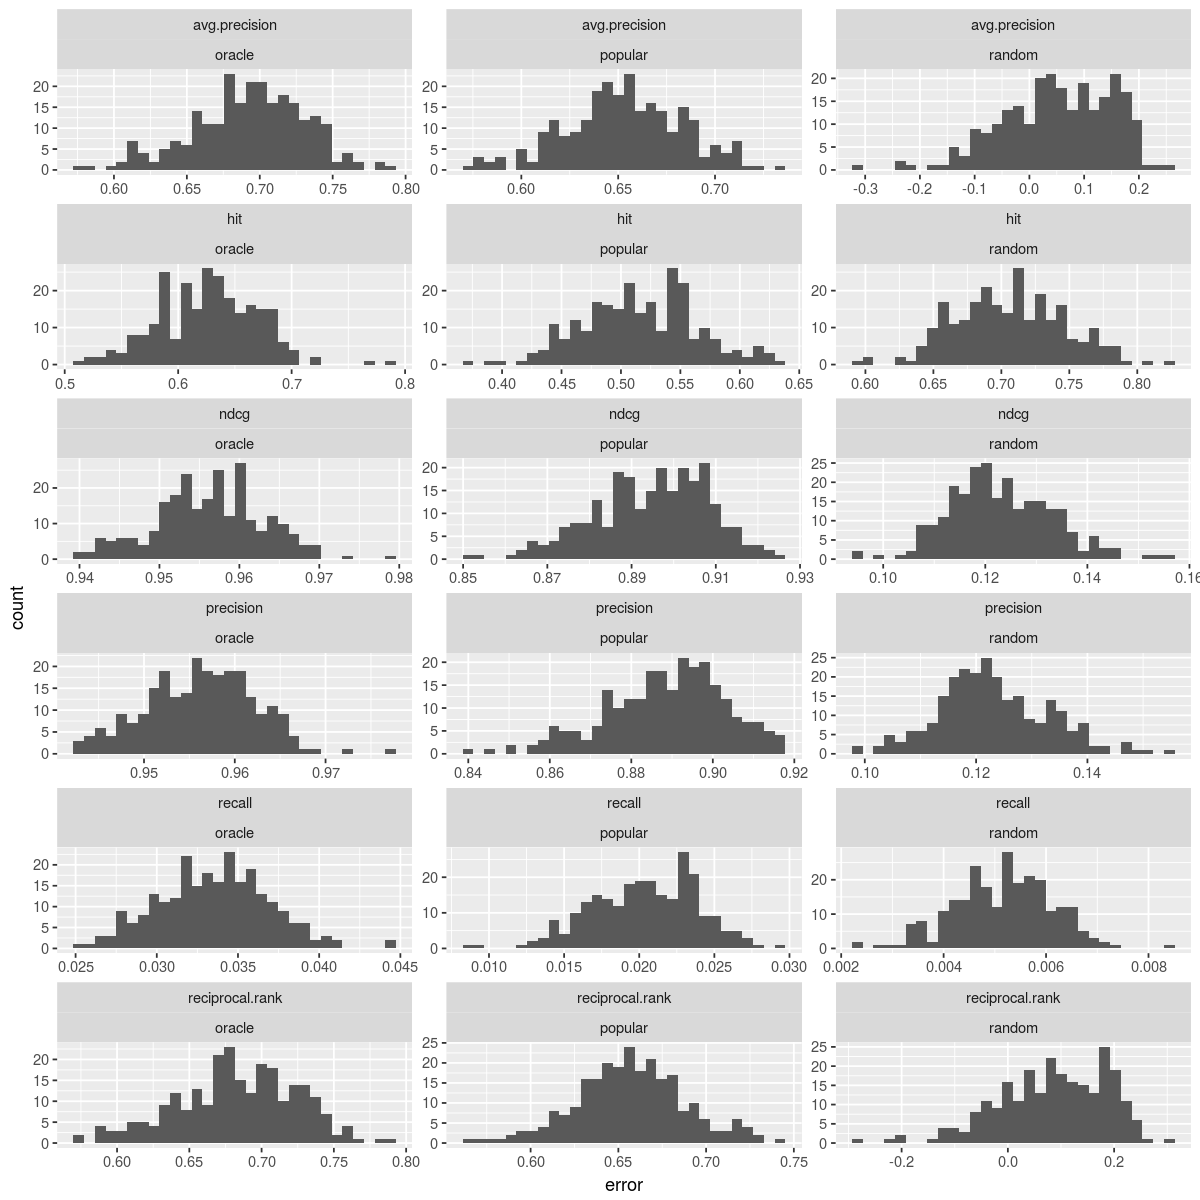

In [6]:
ggplot(error.result) +
    aes(x=error) +
    geom_histogram() +
    facet_wrap(metric~algorithm, ncol = 3, scales="free")